# Higgs Boson Analysis using Spark on Openshift

Note : 
1. To run Spark on Openshift in a Jupyter Notebook, we need to install Open Data Hub which requires OpenShift   Container Platform version 4.8+ and then create a new Python 3 notebook by spawning a new server with spark functionality.
2. This project uses data which is from the 13TeV ATLAS (a detector at CERN) opendata
3. Inspired from Luca Canali's Big Data content

In [1]:
# Importing all the necessary libraries

!pip install pyspark
!pip install sparkhistogram
import os
from pyspark.sql import SparkSession, SQLContext
from sparkhistogram import computeHistogram
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# Downloading the dataset

!wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/ATLAS_Higgs_opendata/MC_signal_4lep.parquet

--2023-04-02 18:01:14--  https://sparkdltrigger.web.cern.ch/sparkdltrigger/ATLAS_Higgs_opendata/MC_signal_4lep.parquet
Resolving sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)... 137.138.31.235, 137.138.124.182, 188.185.5.88, ...
Connecting to sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)|137.138.31.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84796630 (81M)
Saving to: ‘MC_signal_4lep.parquet.2’

MC_signal_4lep.parq 100%[===================>]  80.87M   105MB/s    in 0.8s    

2023-04-02 18:01:15 (105 MB/s) - ‘MC_signal_4lep.parquet.2’ saved [84796630/84796630]



In [3]:
# Starting the session on clusters managed by OpenShift

spark_cluster_url = f"spark://{os.environ['SPARK_CLUSTER']}:7077"
spark = (SparkSession.builder.appName("H_ZZ_4Lep").master("spark_cluster_url").getOrCreate())

In [4]:
# EDA

df_events = spark.read.parquet("MC_signal_4lep.parquet")
df_events.printSchema()

root
 |-- runNumber: integer (nullable = true)
 |-- eventNumber: integer (nullable = true)
 |-- channelNumber: integer (nullable = true)
 |-- mcWeight: float (nullable = true)
 |-- scaleFactor_PILEUP: float (nullable = true)
 |-- scaleFactor_ELE: float (nullable = true)
 |-- scaleFactor_MUON: float (nullable = true)
 |-- scaleFactor_PHOTON: float (nullable = true)
 |-- scaleFactor_TAU: float (nullable = true)
 |-- scaleFactor_BTAG: float (nullable = true)
 |-- scaleFactor_LepTRIGGER: float (nullable = true)
 |-- scaleFactor_PhotonTRIGGER: float (nullable = true)
 |-- trigE: boolean (nullable = true)
 |-- trigM: boolean (nullable = true)
 |-- trigP: boolean (nullable = true)
 |-- lep_n: long (nullable = true)
 |-- lep_truthMatched: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- lep_trigMatched: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- lep_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- le

In [5]:
# Counting the number of events

print(f"Number of events before filtering: {df_events.count()}")

Number of events before filtering: 385706


In [6]:
# Filtering in accordance to Particle Physics theory (filtering Leptons based on charge and type)  

df_events = df_events.filter("lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] == 0")

df_events = df_events.filter("lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3] in (44, 48, 52)")

print(f"Number of events after filtering: {df_events.count()}")

Number of events after filtering: 370040


In [7]:
# Computing the invariant mass

df_4lep = df_events.selectExpr("lep_pt[0] * cos(lep_phi[0]) + lep_pt[1] * cos(lep_phi[1]) + lep_pt[2] * cos(lep_phi[2]) + lep_pt[3] * cos(lep_phi[3]) as Px",
"lep_pt[0] * sin(lep_phi[0]) + lep_pt[1] * sin(lep_phi[1]) + lep_pt[2] * sin(lep_phi[2]) + lep_pt[3] * sin(lep_phi[3]) as Py",
"lep_pt[0] * sinh(lep_eta[0]) + lep_pt[1] * sinh(lep_eta[1]) + lep_pt[2] * sinh(lep_eta[2]) + lep_pt[3] * sinh(lep_eta[3]) as Pz",
"lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] as E")

df_4lep_invmass = df_4lep.selectExpr("sqrt(E * E - ( Px * Px + Py * Py + Pz * Pz))/1e3 as invmass_GeV")

df_4lep_invmass.show(5)

+------------------+
|       invmass_GeV|
+------------------+
|122.68915751101063|
| 113.6591678276742|
|125.39996029333513|
|123.64510277758014|
| 123.5182389789679|
+------------------+
only showing top 5 rows



In [8]:
# Plotting a histogram with energy values and event counts

min_val = 80
max_val = 250
num_bins = (max_val - min_val) / 5.0

histogram_data = computeHistogram(df_4lep_invmass, "invmass_GeV", min_val, max_val, num_bins) 
%time histogram_data_pandas=histogram_data.toPandas()

histogram_data_stat_errors = np.sqrt(histogram_data_pandas)

CPU times: user 63.4 ms, sys: 8.42 ms, total: 71.9 ms
Wall time: 4.8 s


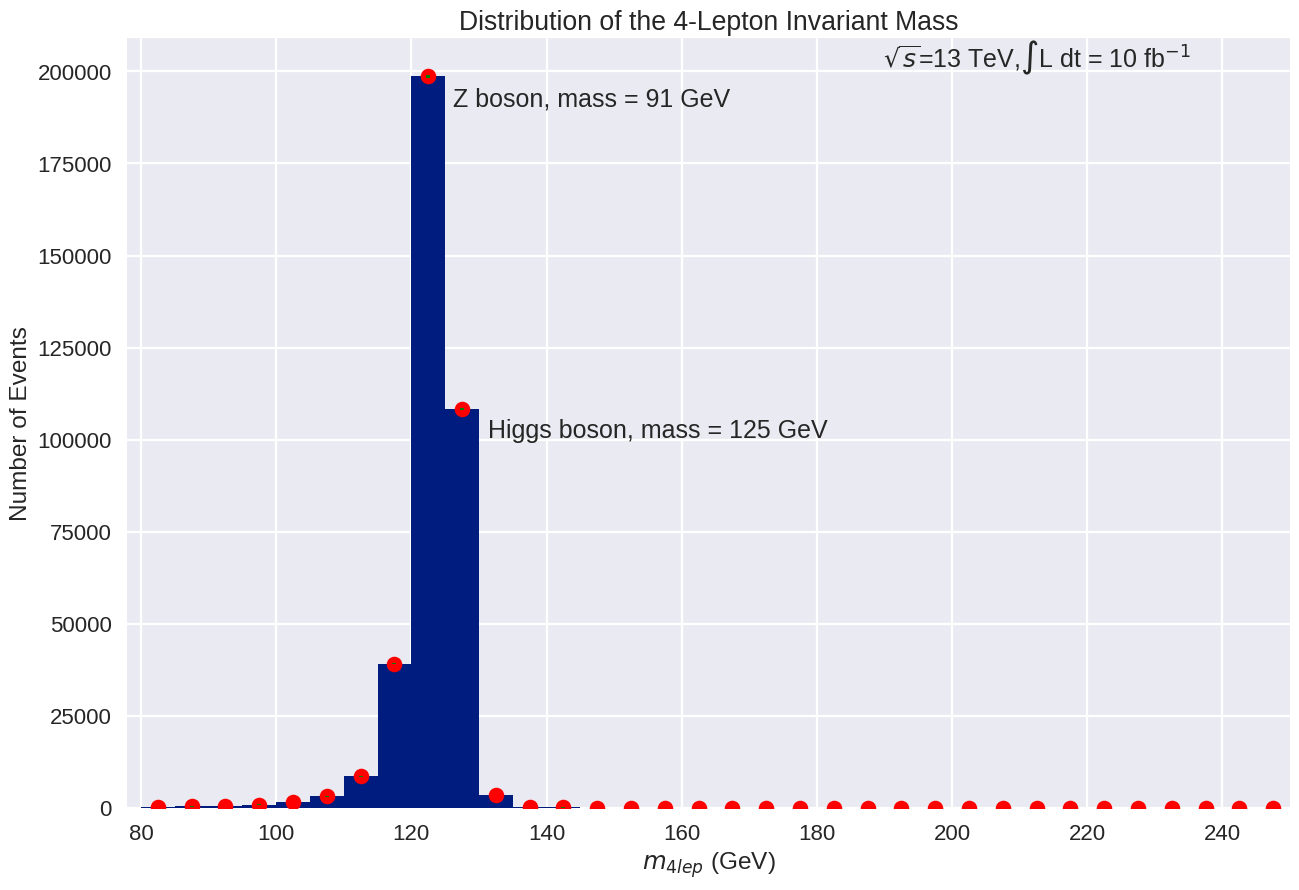

In [9]:
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 18, 'figure.figsize': [15,10]})

f, ax = plt.subplots()

x = histogram_data_pandas["value"]
y = histogram_data_pandas["count"]
err = histogram_data_stat_errors["count"]

ax.plot(x, y, marker='o', color='red', linewidth=0)

ax.bar(x, y, width = 5.0, yerr = err, capsize = 5, linewidth = 0.2, ecolor='green', fill=True)

ax.set_xlim(min_val-2, max_val)

ax.set_xlabel('$m_{4lep}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the 4-Lepton Invariant Mass")

txt_opts = {'horizontalalignment': 'left','verticalalignment': 'center','transform': ax.transAxes}

plt.text(0.28, 0.92, "Z boson, mass = 91 GeV", **txt_opts)
plt.text(0.31, 0.49, "Higgs boson, mass = 125 GeV", **txt_opts)

plt.text(0.65, 0.975, '$\sqrt{s}$=13 TeV,$\int$L dt = 10 fb$^{-1}$', **txt_opts)

plt.show()

In [66]:
spark.stop()